# Handling energy dependent region sizes in RegionGeom

This notebook explores the possibilty to handle energy dependent region size in `RegionGeom` via a new region class and Numpy broadcasting.

The corresponding branch can be found here: https://github.com/adonath/gammapy/tree/region_geom_array

In [1]:
from astropy.coordinates import SkyCoord
from astropy import units as u
from gammapy.maps import WcsGeom, MapAxis, Map, RegionNDMap, RegionGeom
from gammapy.data import EventList
from gammapy.utils.regions import CircleSkyRegionArray
from regions import CircleSkyRegion

In [2]:
radius = [1, 2, 3, 4] * u.deg

# The radius has to be reshaped along the energy axis,
# which is know to be the first ine here. However we would
# need a more simpler / more general solution for this
radius = radius.reshape((-1, 1, 1))

circle = CircleSkyRegionArray(
    center=SkyCoord(83.63 * u.deg, 22.01 * u.deg),
    radius=radius,
)

In [3]:
axis = MapAxis.from_energy_bounds("1 TeV", "10 TeV", nbin=4)

wcs_geom = WcsGeom.create(
    axes=[axis],
    width=10 * u.deg,
    binsz=0.05 * u.deg,
    skydir=circle.center
)

region_geom = RegionGeom.create(
    region=circle,
    axes=[axis],
)

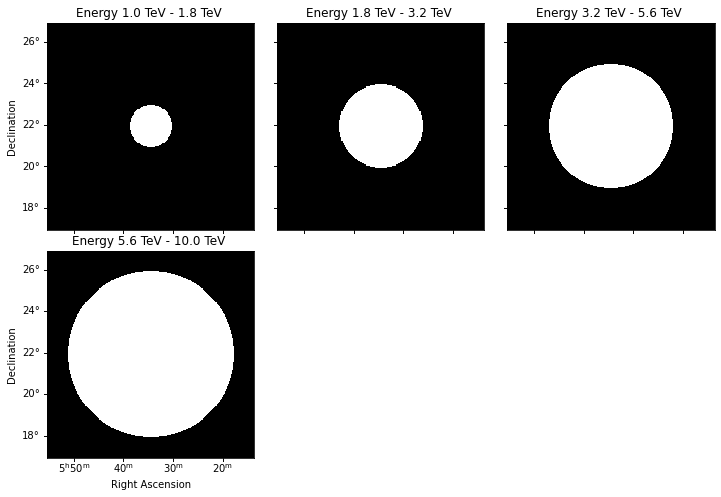

In [4]:
positions = wcs_geom.get_coord()
data = region_geom.contains(positions)
mask = Map.from_geom(geom=wcs_geom, data=data)
mask.plot_grid();

In [5]:
region_geom.center_skydir

<SkyCoord (ICRS): (ra, dec) in deg
    (83.63, 22.01)>

In [6]:
region_geom.center_pix

(0.0, 0.0, 1.5)

In [7]:
region_geom.solid_angle()

<Quantity [[[0.00095698]],

           [[0.00382794]],

           [[0.00861285]],

           [[0.01531174]]] sr>

In [8]:
region_geom.bin_volume()

<Quantity [[[0.0007448 ]],

           [[0.00529786]],

           [[0.0211974 ]],

           [[0.06701317]]] sr TeV>

In [9]:
region_geom.width

<Quantity [8.2, 8.2] deg>

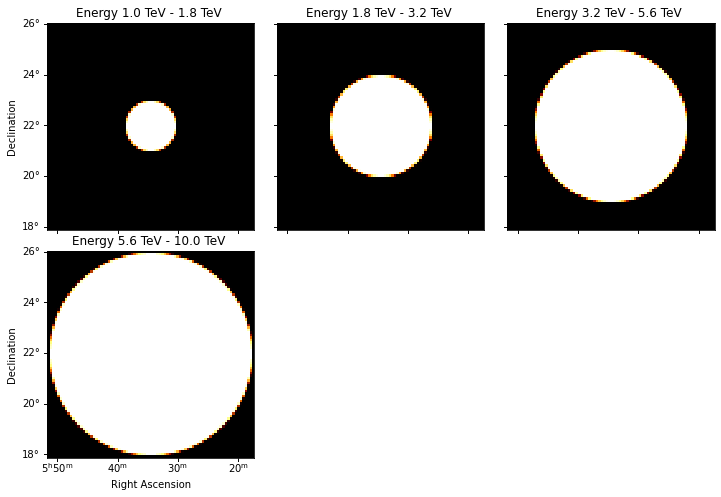

In [10]:
coords, weights = region_geom.get_wcs_coord_and_weights()
weights.plot_grid();

In [11]:
events = EventList.read("$GAMMAPY_DATA/hess-dl3-dr1/data/hess_dl3_dr1_obs_id_023523.fits.gz")

In [12]:
# Reference events per energy bin
for (e_min, e_max), radius in zip(axis.iter_by_edges, circle.radius.flat):
    events_selected = events.select_energy(energy_range=(e_min, e_max))
    region = CircleSkyRegion(center=circle.center, radius=radius)
    events_selected = events_selected.select_region(regions=region)
    print(f"{e_min:.2f} - {e_max:5.2f}: {len(events_selected.table)}")

1.00 TeV -  1.78 TeV: 325
1.78 TeV -  3.16 TeV: 469
3.16 TeV -  5.62 TeV: 457
5.62 TeV - 10.00 TeV: 400


In [13]:
counts = RegionNDMap.from_geom(geom=region_geom)
counts.fill_events(events)
print(counts.data)

[[[325.]]

 [[469.]]

 [[457.]]

 [[400.]]]
